# Solution: Problem 1 (without including time delay)

## First, we install packages that we will need. Skip this step if packages are already installed.

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install astropy
!{sys.executable} -m pip install pycbc

## Import necessary packages

In [1]:
from astropy.cosmology import Planck15
from astropy import constants
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pycbc.psd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from tqdm import tqdm

## Define the star formation rate

In [2]:
def Rstar_z(z):
    """
    The star formation rate as a function of redshift.
    Normalized to the merger rate from GWTC-2
    https://arxiv.org/abs/2010.14533
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 23.9 / u.yr / u.Gpc ** 3 # BBH merger rate
    numerator = nu * a * np.exp(b * (z - zm))
    denominator = a - b + b * np.exp(a * (z - zm))
    return numerator / denominator

In [3]:
def dEdf(freq, factor):
    """
    Function to calculate dE/df for compact binaries.
    The factor is the integral of the chirp mass distribution
    as defined in the notes.
    """
    
    numerator =  np.pi ** (2/3) * constants.G ** (2/3) * factor * freq ** (-1/3)
    denominator = 3  * constants.c ** 2
    return numerator / denominator

def omega_GW_without_time_delay(f_arr, chirp_mass_distribution,
                               extra_args=dict()):
    """
    Function to calculate omega_gw given the chirp mass
    distribution. Also takes extra_args that go into the 
    the distribution for chirp mass.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    if chirp_mass_distribution == "delta_function":
        factor = extra_args["val"] ** (5/3) * u.M_sun ** (5/3)
    
    else:
        delta_chirp_mass = 0.1
        chirp_mass_arr = np.arange(0, 200, delta_chirp_mass)
        factor_integrand = chirp_mass_arr ** (5/3) * chirp_mass_distribution(chirp_mass_arr, **extra_args)
        factor = np.sum(factor_integrand) * delta_chirp_mass  * u.M_sun ** (5/3)
        print(factor)
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck15.critical_density0 * Planck15.H0) 
        integrand = Rstar_z(z) / (1 + z) * Planck15.inv_efunc(z) * dEdf(freq / (1 + z), factor) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result



## Define a few distributions.

In [4]:
def gaussian(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp((x - mu) ** 2  / 2 / sigma **2)

def flat(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / (maximum - minimum)
    return y

## Calculate omega_gw and compare with the PSD scaled with the constants.

498it [00:01, 401.64it/s]
498it [00:01, 413.78it/s]


(5, 1000)

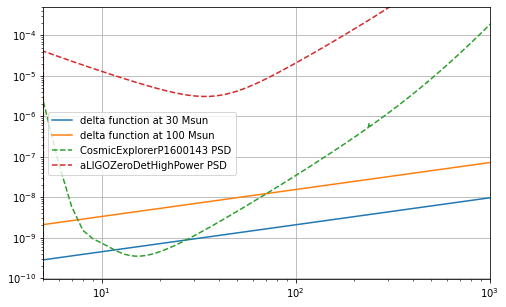

In [8]:
plt.figure(figsize=(8,5))

f_arr = np.arange(5, 1000, 2)
for chirp_mass in [30, 100]:
    omega = omega_GW_without_time_delay(f_arr, "delta_function", extra_args=dict(val=chirp_mass),)
    plt.loglog(f_arr, omega, label=f"delta function at {chirp_mass} Msun")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck15.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")
plt.legend(loc="best")
plt.ylim(ymax=5e-4)
plt.grid()
plt.xlim(5, 1000)